# Sentiment Analysis

### importing libraries

In [1]:
#!pip install pandas scikit-learn nltk joblib matplotlib seaborn

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
from sklearn.pipeline import Pipeline
import joblib
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
warnings.filterwarnings("ignore")

# Download stopwords
nltk.download('stopwords', quiet=True)
STOP_WORDS = set(stopwords.words('english'))



### Loading data

In [2]:
# Update this path if needed
FILEPATH = "judge-1377884607_tweet_product_company.csv"  # or use URL if hosted

# Load data
df = pd.read_csv(FILEPATH, encoding='latin1')
print(f"Loaded {len(df)} rows.")

# Inspect first few rows



Loaded 9093 rows.


In [3]:
display(df.head(20))


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [4]:
df.columns


Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [5]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [6]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

Since our main focus is to check the tweet we will remove the null values

In [7]:
df = df.dropna(subset=['tweet_text'])


<Figure size 1200x800 with 0 Axes>

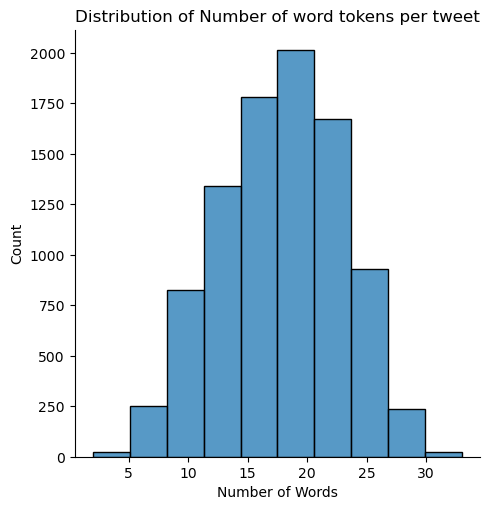

In [8]:
num_words_per_tweet = df['tweet_text'].apply(
    lambda text: len(text.split())
)

plt.figure(figsize=(12,8))
sns.displot(num_words_per_tweet, bins=10)
plt.xlabel("Number of Words")
plt.title("Distribution of Number of word tokens per tweet")
plt.show()

In [9]:
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace('No emotion toward brand or product', 'Neutral emotion')

### Text preporocessing

In [10]:
def clean_tweet(text):
    """Clean tweet text for modeling."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  
    text = re.sub(r'@\w+', '', text)  
    text = re.sub(r'#\w+', '', text)  
    text = re.sub(r'[^a-z\s]', ' ', text)  
    text = ' '.join(text.split())  
    return text

df['tweet_text'] = df['tweet_text'].apply(clean_tweet)

print("\nCleaned tweet:\n", df['tweet_text'].iloc[0])



Cleaned tweet:
 i have a g iphone after hrs tweeting at it was dead i need to upgrade plugin stations at


In [11]:
# tokenization of benefitsReview column
df['tweet_text_tokenized'] = df['tweet_text'].apply(lambda x: word_tokenize(x))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_tokenized
0,i have a g iphone after hrs tweeting at it was...,iPhone,Negative emotion,"[i, have, a, g, iphone, after, hrs, tweeting, ..."
1,know about awesome ipad iphone app that you ll...,iPad or iPhone App,Positive emotion,"[know, about, awesome, ipad, iphone, app, that..."
2,can not wait for also they should sale them do...,iPad,Positive emotion,"[can, not, wait, for, also, they, should, sale..."
3,i hope this year s festival isn t as crashy as...,iPad or iPhone App,Negative emotion,"[i, hope, this, year, s, festival, isn, t, as,..."
4,great stuff on fri marissa mayer google tim o ...,Google,Positive emotion,"[great, stuff, on, fri, marissa, mayer, google..."


In [12]:
# remove non words: numbers, symbols
df['tweet_text_tokenized'] = df['tweet_text_tokenized'].apply(lambda x: [word for word in x if word.isalpha()])
# removal of stop words
df['tweet_text_tokenized'] = df['tweet_text_tokenized'].apply(lambda x: [word.lower() for word in x if word.lower() not in stopwords.words()])
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_tokenized
0,i have a g iphone after hrs tweeting at it was...,iPhone,Negative emotion,"[g, iphone, hrs, tweeting, dead, upgrade, plug..."
1,know about awesome ipad iphone app that you ll...,iPad or iPhone App,Positive emotion,"[awesome, ipad, iphone, app, appreciate, desig..."
2,can not wait for also they should sale them do...,iPad,Positive emotion,[wait]
3,i hope this year s festival isn t as crashy as...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, iphone, app]"
4,great stuff on fri marissa mayer google tim o ...,Google,Positive emotion,"[great, stuff, fri, marissa, mayer, google, ti..."


In [13]:
df['tweet_text_tokenized_str'] = df['tweet_text_tokenized'].apply(lambda x: " ".join(x))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_tokenized,tweet_text_tokenized_str
0,i have a g iphone after hrs tweeting at it was...,iPhone,Negative emotion,"[g, iphone, hrs, tweeting, dead, upgrade, plug...",g iphone hrs tweeting dead upgrade plugin stat...
1,know about awesome ipad iphone app that you ll...,iPad or iPhone App,Positive emotion,"[awesome, ipad, iphone, app, appreciate, desig...",awesome ipad iphone app appreciate design givi...
2,can not wait for also they should sale them do...,iPad,Positive emotion,[wait],wait
3,i hope this year s festival isn t as crashy as...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app
4,great stuff on fri marissa mayer google tim o ...,Google,Positive emotion,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...


Bag of words

In [14]:
# Create a bag of words: Unigrams
reviews_complete = " ".join(df['tweet_text_tokenized_str'])
count_vectorizer = CountVectorizer(lowercase=True, ngram_range=(1, 1), stop_words="english")
sparse_matrix = count_vectorizer.fit_transform([reviews_complete])
counts_df = pd.DataFrame(sparse_matrix.toarray(),columns=count_vectorizer.get_feature_names_out())
counts_df = counts_df.T
counts_df.reset_index(inplace=True)
counts_df.columns = ['word','count']
# sort by frequency descending orde
counts_df.sort_values(by='count',ascending=False,inplace=True)
# filter to return only num_top rows
counts_df = counts_df.iloc[:10,:]
print(counts_df)

        word  count
3882    link   4313
5727      rt   2970
3495    ipad   2440
2848  google   2342
277    apple   1918
5313    quot   1696
6420   store   1485
3501  iphone   1325
400   austin    861
208      amp    836


In [15]:
# Create a bag of words: Bigrams
reviews_complete = " ".join(df['tweet_text_tokenized_str'])
count_vectorizer = CountVectorizer(lowercase=True, ngram_range=(2, 2), stop_words="english")
sparse_matrix = count_vectorizer.fit_transform([reviews_complete])
counts_df = pd.DataFrame(sparse_matrix.toarray(),columns=count_vectorizer.get_feature_names_out())
counts_df = counts_df.T
counts_df.reset_index(inplace=True)
counts_df.columns = ['word','count']
# sort by frequency descending orde
counts_df.sort_values(by='count',ascending=False,inplace=True)
# filter to return only num_top rows
counts_df = counts_df.iloc[:10,:]
print(counts_df)

                 word  count
17543         link rt   1011
1767      apple store    556
27518  social network    452
25408       rt google    345
22474       pop store    341
11287   google launch    329
20218  network called    326
30475      today link    312
4363   called circles    303
18588    major social    291


### Word cloud

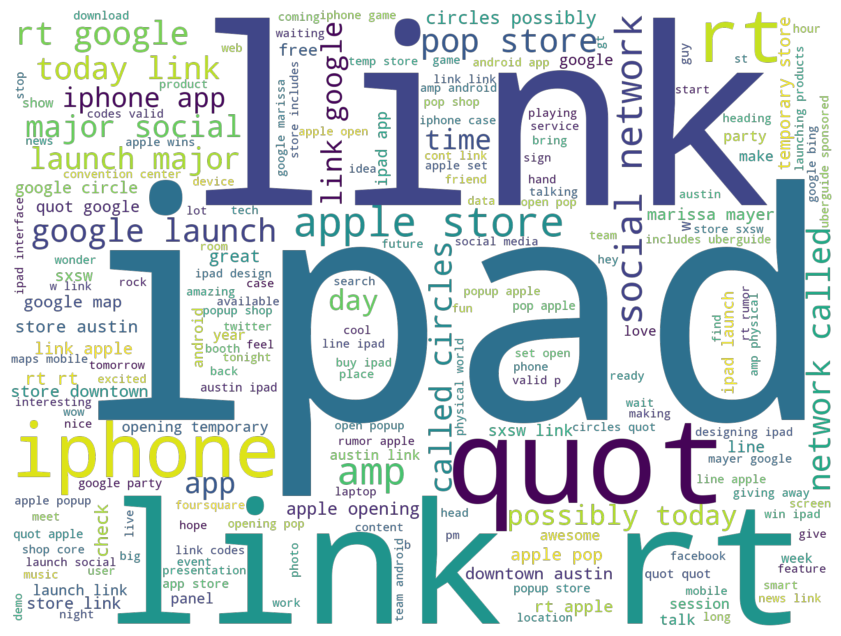

In [16]:
# visualize a wordcloud of benefitsReview column
#reviews_corpus = " ".join()

plt.figure(figsize=(12,8))
wordcloud = WordCloud(
    width=2000,
    height=1500,
    #stopwords=stop_words,
    background_color=None,
    mode='RGBA'
).generate_from_text(reviews_complete)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Vader

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon (run once)
nltk.download('vader_lexicon', quiet=True)

# Initialize analyzer
analyzer = SentimentIntensityAnalyzer()

# Compute polarity scores
df['vader_polarity'] = df['tweet_text_tokenized_str'].apply(
    lambda text: analyzer.polarity_scores(str(text))['compound']
)

# Define 3-class sentiment using thresholds
def classify_vader_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment'] = df['vader_polarity'].apply(classify_vader_sentiment)

# View results
df[['tweet_text_tokenized_str', 'vader_polarity', 'vader_sentiment']].head(20)

,tweet_text_tokenized_str,vader_polarity,vader_sentiment
0,g iphone hrs tweeting dead upgrade plugin stat...,-0.6486,Negative
1,awesome ipad iphone app appreciate design givi...,0.9100,Positive
2,wait,0.0000,Neutral
3,hope year festival crashy year iphone app,0.7269,Positive
4,great stuff fri marissa mayer google tim reill...,0.6249,Positive
5,ipad apps communication showcased conference,0.0000,Neutral
7,starting corner hop skip jump time,0.0000,Neutral
8,beautifully smart simple idea rt wrote ipad app,0.7506,Positive
9,counting days strong canadian dollar means sto...,0.5106,Positive
10,excited meet show sprint galaxy running android,0.3400,Positive


In [18]:
# perform sentiment analysis using Vader/Textblob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

df['vader_polarity'] = df['tweet_text_tokenized_str'].map(
    lambda text: analyzer.polarity_scores(text)['compound']
)

def classify_vader_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment'] = df['vader_polarity'].apply(classify_vader_sentiment)
df.head(20)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_tokenized,tweet_text_tokenized_str,vader_polarity,vader_sentiment
0,i have a g iphone after hrs tweeting at it was...,iPhone,Negative emotion,"[g, iphone, hrs, tweeting, dead, upgrade, plug...",g iphone hrs tweeting dead upgrade plugin stat...,-0.6486,Negative
1,know about awesome ipad iphone app that you ll...,iPad or iPhone App,Positive emotion,"[awesome, ipad, iphone, app, appreciate, desig...",awesome ipad iphone app appreciate design givi...,0.9100,Positive
2,can not wait for also they should sale them do...,iPad,Positive emotion,[wait],wait,0.0000,Neutral
3,i hope this year s festival isn t as crashy as...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,0.7269,Positive
4,great stuff on fri marissa mayer google tim o ...,Google,Positive emotion,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,0.6249,Positive
5,new ipad apps for and communication are showca...,NaN,Neutral emotion,"[ipad, apps, communication, showcased, confere...",ipad apps communication showcased conference,0.0000,Neutral
7,is just starting is around the corner and is o...,Android,Positive emotion,"[starting, corner, hop, skip, jump, time]",starting corner hop skip jump time,0.0000,Neutral
8,beautifully smart and simple idea rt wrote abo...,iPad or iPhone App,Positive emotion,"[beautifully, smart, simple, idea, rt, wrote, ...",beautifully smart simple idea rt wrote ipad app,0.7506,Positive
9,counting down the days to plus strong canadian...,Apple,Positive emotion,"[counting, days, strong, canadian, dollar, mea...",counting days strong canadian dollar means sto...,0.5106,Positive
10,excited to meet the at so i can show them my s...,Android,Positive emotion,"[excited, meet, show, sprint, galaxy, running,...",excited meet show sprint galaxy running android,0.3400,Positive


## Vader visual

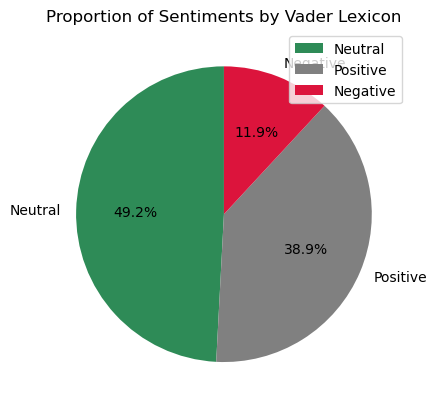

In [19]:
fig, ax = plt.subplots()
colors = ("#2E8B57","#808080","#DC143C")
sentiment_props = df['vader_sentiment'].value_counts()
ax.pie(sentiment_props.values, colors=colors, labels=sentiment_props.index, autopct="%1.1f%%", startangle=90)
plt.title("Proportion of Sentiments by Vader Lexicon")
plt.legend(loc='upper right')
plt.show()